In [1]:
from IPython.display import Latex

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.special import erf
from matplotlib.backends.backend_pdf import PdfPages

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

$V_{max}$  $\delta V_{max}$     $x_0$  $\delta x_0$  $\omega$  \
0   8.817048          0.008623  0.002632      0.000002  0.001899   
1   8.777974          0.008034  0.003152      0.000002  0.001991   
2   8.740252          0.003739  0.004545      0.000002  0.002093   
3   8.731980          0.005134  0.004698      0.000002  0.002199   
4   8.726917          0.005828  0.004776      0.000003  0.002278   

   $\delta \omega$  
0         0.000006  
1         0.000006  
2         0.000004  
3         0.000006  
4         0.000007

\begin{tabular}{lrrrrrr}
\toprule
{} &  \$V\_\{max\}\$ &  \$\textbackslash delta V\_\{max\}\$ &     \$x\_0\$ &  \$\textbackslash delta x\_0\$ &  \$\textbackslash omega\$ &  \$\textbackslash delta \textbackslash omega\$ \\
\midrule
0 &   8.817048 &          0.008623 &  0.002632 &      0.000002 &  0.001899 &         0.000006 \\
1 &   8.777974 &          0.008034 &  0.003152 &      0.000002 &  0.001991 &         0.000006 \\
2 &   8.740252 &          0.003739 &  0.004545 &      0.000002 &  0.002093 &         0.000004 \\
3 &   8.731980 &          0.005134 &  0.004698 &      0.000002 &  0.002199 &         0.000006 \\
4 &   8.726917 &          0.005828 &  0.004776 &      0.000003 &  0.002278 &         0.000007 \\
\bottomrule
\end{tabular}



z  $\delta z$  $\omega$  $\delta \omega$
0  0.00    0.001000  0.001899         0.000006
1  0.38    0.001414  0.001991         0.000006
2  0.75    0.001414  0.002093         0.000004
3  1.04    0.001414  0.002199         0.000006
4  1.33    0.001414  0.002278         0.000007

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

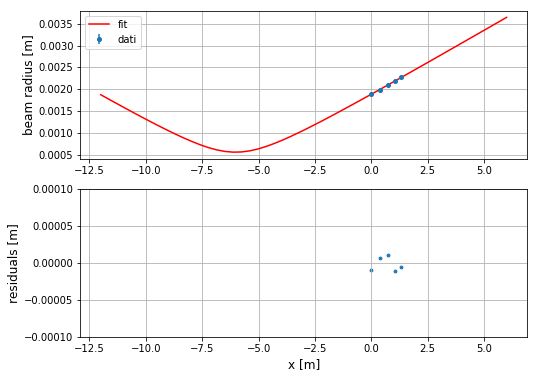

In [6]:
pp = PdfPages('multipage.pdf')
plt.rcParams['figure.figsize'] = (8, 6)
w_ = np.ones(10).reshape((5,2))
ps = np.ones(30).reshape((5,6))
for i in range(5):
    df = pd.read_csv(f'data/gauss{i+1}.csv')
    sigma_v = 1e-3*np.ones(len(df))
    f = lambda x, p0, x0, w: p0/2*(1 -  erf(np.sqrt(2)*(x-x0)/w))
    popt, pcov = optimize.curve_fit(f, df.displ*1e-3, df.volt, sigma=sigma_v)
    perr = np.sqrt(np.diag(pcov))
    w_[i] = (popt[2], perr[2])
    ps[i] = (popt[0], perr[0], popt[1], perr[1], popt[2], perr[2])
    chi = sum((f(df.displ.values*1e-3, *popt) - df.volt)**2 / sigma_v**2)
    display(Latex(f'$\chi^2_{i+1} = {int(chi)}$ at {len(df)-2} dof'))
    
    if i == 2:
        fig1 = plt.figure()
        x = np.linspace(0, 8*1e-3)
        ax1 = fig1.add_subplot(211)
        ax2 = fig1.add_subplot(212, sharex=ax1)
        ax1.errorbar(df.displ*1e-3, df.volt, fmt='.', yerr=sigma_v, markersize=8, label='dati')
        ax1.plot(x, f(x, *popt), label='fit', color='r')
        #ax1.set_xlabel('x [m]', fontsize=12)
        ax1.set_ylabel('$V_{exp}$ [V]', fontsize=12)
        #ax1.set_title('Esempio di fit di V(x) per un valore di z', fontsize=14, weight='bold')
        ax1.grid()
        ax1.legend()
        # residual
        ax2.scatter(df.displ*1e-3, f(df.displ.values*1e-3, *popt) - df.volt, s=8)
        #ax2.set_xlim(-0.0002, 0.0055)
        ax2.set_xlabel('x [m]', fontsize=12)
        ax2.set_ylabel('residuals [V]', fontsize=12)
        #ax2.title('Residui fit di V(x) per un valore di z', fontsize=14, weight='bold')
        ax2.grid()
        pp.savefig()

show = pd.DataFrame(ps, columns=['$V_{max}$', '$\delta V_{max}$', 
                                 '$x_0$', '$\delta x_0$', 
                                 '$\omega$', '$\delta \omega$'])
display(show)
print(show.to_latex())

LAMBDA = 532e-9
zs = pd.read_csv('data/z.csv')
zs['z'] = zs['z'][0] - zs['z']
zs['$\omega$'] = w_[:, 0]
zs['$\delta \omega$'] = w_[:, 1]
col = list(zs.columns)
col.remove('sigma')
col.insert(1, '$\delta z$')
zs.columns = col.copy()
display(zs)
z_ = zs['z'].values
f_ = lambda z, w0, z0: w0 * np.sqrt(1 + ((z-z0)*LAMBDA / (np.pi*w0**2))**2)
popt, pcov = optimize.curve_fit(f_, z_, w_[:, 0], sigma=w_[:, 1])
perr = np.sqrt(np.diag(pcov))

fig2 = plt.figure()
ax3 = fig2.add_subplot(211)
ax4 = fig2.add_subplot(212, sharex=ax3)
x = np.linspace(-12, 6)
ax3.errorbar(z_, w_[:, 0], fmt='.', yerr=w_[:, 1], markersize=8, label='dati')
ax3.plot(x, f_(x, *popt), label='fit', color='r')
ax3.set_ylabel('beam radius [m]', fontsize=12)
#ax3.set_title('Fit di $\omega$(z)', fontsize=14, weight='bold')
ax3.grid()
ax3.legend()

ax4.scatter(z_, f_(z_, *popt) - w_[:, 0], s=8)
ax4.set_ylim(-0.0001, 0.0001)
ax4.set_xlabel('x [m]', fontsize=12)
ax4.set_ylabel('residuals [m]', fontsize=12)
#ax4.title('Residui fit di $\omega$(z)', fontsize=14, weight='bold')
ax4.grid()
pp.savefig()

chi = sum((f_(z_, *popt) - w_[:, 0])**2 / w_[:, 1]**2)

display(Latex(f'$\chi^2 = {int(chi)}$ at 3 dof'))
display(Latex(f'$\omega_0 = ({popt[0]:.5f} \pm {perr[0]:.5f})\ m$'))
display(Latex(f'$z_0 = ({popt[1]:.1f} \pm {perr[1]:.1f})\ m$'))

pp.close()